# Generate Gaussian Samples

## Positive Samples

We are going to demostrate the RBF network for 3 dimensional Guassian distribution.

In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
pd.set_option("display.max_rows",15)
import matplotlib.pyplot as plt
import math
import sys
from tensorflow.python import debug as tf_debug

%matplotlib inline

In [2]:
class hp:
    n = 1000
    f = 2

train_mean = np.full(shape=(hp.f), fill_value = 0.5)
train_var = [[1,0.6],[0.2,3]]
train_var = np.matmul(train_var, np.transpose(train_var)) # To make sure that the covariance matrix in positive semi-definate

test_mean_1 = np.full(shape=(hp.f), fill_value = 1.2)
test_var_1 = [[1,1.6],[0.6,2]]
test_var_1 = np.matmul(test_var_1, np.transpose(test_var_1))

test_mean_2 = np.full(shape=(hp.f), fill_value = 10)
test_var_2 = [[1,0.6],[2.2,3]]
test_var_2 = np.matmul(test_var_2, np.transpose(test_var_2))

test_mean_3 = np.full(shape=(hp.f), fill_value = 20)
test_var_3 = [[1,0.6],[0.2,3]]
test_var_3 = np.matmul(test_var_3, np.transpose(test_var_3))


class Dataset:
    train_positive = pd.DataFrame(
        np.random.multivariate_normal(mean=train_mean, cov=train_var, size = hp.n))
    
    test_negative_1 = pd.DataFrame(
        np.random.multivariate_normal(mean=test_mean_1, cov=test_var_1, size = hp.n))
    
    test_negative_2 = pd.DataFrame(
        np.random.multivariate_normal(mean=test_mean_2, cov=test_var_2, size = hp.n))
    
    test_negative_3 = pd.DataFrame(
        np.random.multivariate_normal(mean=test_mean_3, cov=test_var_3, size = hp.n))
    

## Negative Samples

In [3]:
Dataset.train_positive

,0,1
0,0.674134,1.957754
1,0.620831,-1.925195
2,-0.951604,0.593785
3,0.725283,3.369956
4,0.826188,1.549038
5,-0.096829,-3.582275
6,-0.207143,-4.779035
...,...,...
993,2.257511,1.060654
994,1.644822,-0.467064


Training Data (Normal)

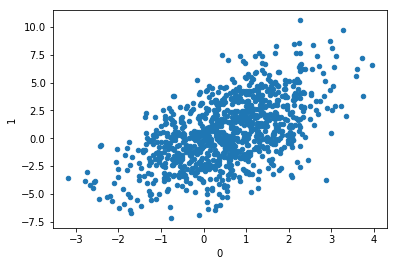

In [4]:
Dataset.train_positive.plot.scatter(x=0, y=1)

Testing Data 1 (Anamoly)

Similar Mean Different Variation

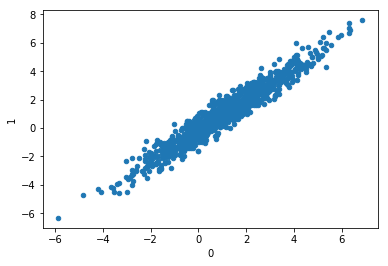

In [5]:
Dataset.test_negative_1.plot.scatter(x=0, y=1)

Testing Data 2 (Anamoly)

Different Mean Different Variation

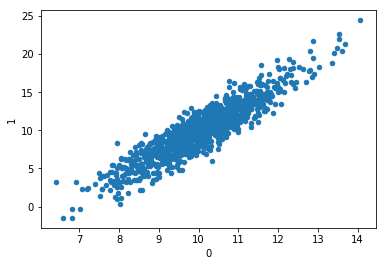

In [6]:
Dataset.test_negative_2.plot.scatter(x=0, y=1)

Testing Data 3 (Anamoly)

Different Mean similar Variation 

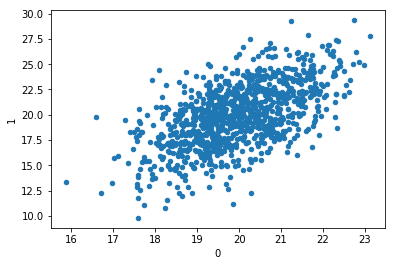

In [7]:
Dataset.test_negative_3.plot.scatter(x=0, y=1)

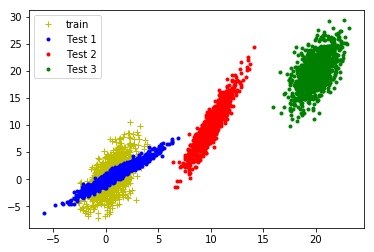

In [8]:
plt.plot(Dataset.train_positive[0], Dataset.train_positive[1], 'y+', label='train')

plt.plot(Dataset.test_negative_1[0], Dataset.test_negative_1[1], 'b.', label='Test 1')
plt.plot(Dataset.test_negative_2[0], Dataset.test_negative_2[1], 'r.', label='Test 2')
plt.plot(Dataset.test_negative_3[0], Dataset.test_negative_3[1], 'g.', label='Test 3')
plt.legend()

In [9]:
class network:
    
    params = {}
    
    def __init__(self):
        with tf.name_scope('Input'):
            self.X = tf.placeholder(tf.float32, [hp.n, hp.f],name='Variable_X') #hp.n, hp.f
        
    def get_cost(self, U, Z, Q): #U, Q, Q_, Z
        
        #inverse_regularizer = tf.pow((tf.matmul(Q,tf.transpose(Q)) - tf.eye(hp.f)), 2)
        cost = - (-U - tf.log(Z)) #+ tf.reduce_sum(inverse_regularizer,axis =1) # get -ve log likelihood
        
        #self.params.update({'U':tf.reduce_mean(U)}) #, 'ir': tf.reduce_sum(inverse_regularizer)
        return tf.reduce_mean(cost)
    
    def get_optimizer(self):
        
        with tf.name_scope('Weights'):
            n = hp.n
            f = hp.f

            X = self.X

            P = tf.Variable(tf.truncated_normal([f]))
            Q_ = tf.Variable(tf.truncated_normal([f])) 
            #Q_ = tf.Variable(tf.truncated_normal([f,f])) 
            global_step = tf.Variable(0, trainable=False)
            
        with tf.name_scope('RBF'):
            Q = tf.diag(tf.square(Q_)) + tf.eye(f) 
            #Q = tf.matmul(Q_, tf.transpose(Q_)) # Making is positive semi-definite

            X = tf.layers.dense(X, f)
            X = tf.layers.dense(X, f)

            M = P - tf.matmul(X, Q)
            print('M', M.get_shape())

            R = tf.matmul(M, Q)
            print('R', R.get_shape())

            V = tf.matmul(R, tf.transpose(M))
            print('V', V.get_shape())

            U = tf.reduce_sum(V, axis = 1, keepdims = True)
            print('U', U.get_shape())

            Q_det = tf.matrix_determinant(Q)
            print('Q_det', Q_det.get_shape())

            Z = tf.pow(tf.multiply(tf.pow(2*math.pi,f), Q_det), 1/2)
            print('Z', Z.get_shape())
        
        with tf.name_scope('Likelihood'):
            Y_ = tf.divide(tf.exp(-U/2), Z)
            print("Y_", Y_.get_shape())
            
        with tf.name_scope('LossAndOptim'):
            loss = self.get_cost(U, Z, Q) # 1- Y_[0]
            tf.summary.scalar('loss', loss)

            starter_learning_rate = 0.01
            learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step,
                                               1000, 0.6, staircase=True)
            train = tf.train.AdamOptimizer(learning_rate).minimize(loss, global_step=global_step)
            tf.summary.scalar("learning_rate",learning_rate)
            
        merged = tf.summary.merge_all()
        
        self.params.update({'U': U, 'P':P, 'Q':Q, 'Z':Z, 'Q_det':Q_det, 'Y_':Y_}) #  

        return merged, train, loss, Y_, self.params


In [10]:
epochs = 20000
loss_arr = []
Dataset.Y_ = []

net = network()
output_tensors = net.get_optimizer()

# tf_debug.TensorBoardDebugWrapperSession(tf.Session(), 'localhost:6064')

with tf.Session() as sess:

    train_writer = tf.summary.FileWriter('logdir/rbf_train', sess.graph)
    
    sess.run(tf.global_variables_initializer())
    
    for epoch in range(epochs):
        
        X = np.reshape(Dataset.train_positive.values, (hp.n, -1))
        
        #for i in range(X.shape[0]):
        #x = X#[i,:].reshape((1,-1))
        
        merged, train, loss, Y_, params = sess.run(output_tensors, feed_dict={net.X:X}) 
        
        train_writer.add_summary(merged, epoch)
        loss_arr.append(loss)

        if(epoch % 500 == 0):
            print("epoch", epoch, "loss", loss)#, 'U', params['U'], 'Z', params['Z']) #, 'IR', params['ir'], 'Z', params['Z'], 'U', params['U']

        Dataset.Y_.append(Y_)
        
    print('P (Mean)', params['P'])
    print('Q (Covariance)', params['Q'])

M (1000, 2)
R (1000, 2)
V (1000, 1000)
U (1000, 1)
Q_det ()
Z ()
Y_ (1000, 1)
epoch 0 loss 70062.76
epoch 500 loss 2.7793899
epoch 1000 loss 2.7745714
epoch 1500 loss 2.7703354
epoch 2000 loss 2.7644753
epoch 2500 loss 2.7598183
epoch 3000 loss 2.753808
epoch 3500 loss 2.749206
epoch 4000 loss 2.7431915
epoch 4500 loss 2.7385085
epoch 5000 loss 2.7325914
epoch 5500 loss 2.728061
epoch 6000 loss 2.7223966
epoch 6500 loss 2.7180521
epoch 7000 loss 2.7124524
epoch 7500 loss 2.7082014
epoch 8000 loss 2.7028565
epoch 8500 loss 2.69872
epoch 9000 loss 2.6935437
epoch 9500 loss 2.689648
epoch 10000 loss 2.6846294
epoch 10500 loss 2.680999
epoch 11000 loss 2.6763625
epoch 11500 loss 2.6728942
epoch 12000 loss 2.6687155
epoch 12500 loss 2.6658137
epoch 13000 loss 2.66243
epoch 13500 loss 2.660002
epoch 14000 loss 2.657517
epoch 14500 loss 2.6558964
epoch 15000 loss 2.654109
epoch 15500 loss 2.6530752
epoch 16000 loss 2.6519234
epoch 16500 loss 2.6512897
epoch 17000 loss 2.6505408
epoch 17500 lo

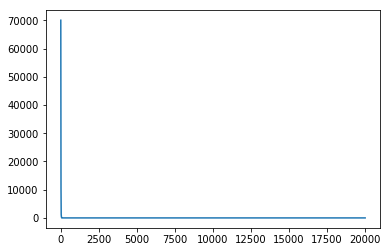

In [11]:
plt.plot(loss_arr)

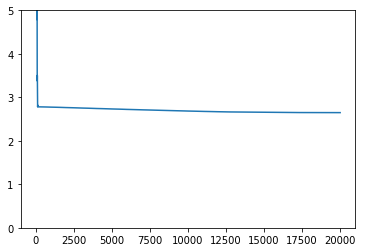

In [12]:
plt.ylim(0, 5)
plt.plot(loss_arr)

(array([  6.,  26.,  62., 177., 224., 234., 154.,  83.,  24.,  10.]),
 array([0.06834657, 0.06882477, 0.06930297, 0.06978116, 0.07025936,
        0.07073755, 0.07121575, 0.07169394, 0.07217214, 0.07265033,
        0.07312853]),
 <a list of 10 Patch objects>)

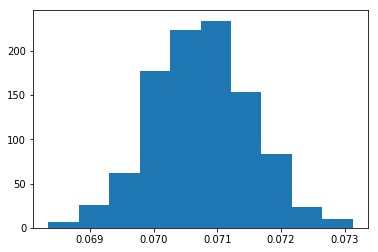

In [13]:
plt.hist(x=params['Y_'].ravel())